In [ ]:
from psrpop import *
import numpy as np
import matplotlib.pyplot as plt
from oompy import Units as u
import pygedm

/opt/anaconda3/envs/psr/lib/python3.11/site-packages/pygedm/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename, get_distribution, DistributionNotFound


In [ ]:
from scipy.interpolate import RegularGridInterpolator

def MW_Radial(R, R1, RSun, a, b):
    return ((R + R1) / (RSun + R1)) ** a * np.exp(-b * (R - RSun) / (RSun + R1))


def MW_Z(z, hc):
    return np.exp(-np.abs(z) / hc)


PARAMETERS = {
    "init_model": {
        "radial_distribution": Distribution(
            xmin=0, xmax=20, pdf=MW_Radial, R1=0.55, RSun=8.5, a=1.64, b=4.0
        ),
        "z_distribution": Distribution(xmin=-5, xmax=5, pdf=MW_Z, hc=0.18),
        "Bsurf": {
            "mean_log10": 12.65,
            "std_log10": 0.55,
        },
        "P": {
            "mean": 0.3,
            "std": 0.15,
            "threshold": 0.85e-3,
        },
    },
    "detectability": {
        "h_em": 3e5 * u.m,
        "tau_scat_coeff": 1.0,
        "tau_DM_coeff": 1.0,
        "tau_scat_coeff": 1.0,
        "tau_samp_coeff": 1.0,
    },
    "dummy": {},
}
dmgrid = np.load("dm_grid.npz")

pulsars = Simulate_Evolution(
    PARAMETERS,
    birth_rate=2 / 100,
    total_time=1e3,
    nbraking=2.5,
    beta=0.05,
    dm_interpolator= RegularGridInterpolator(
    (dmgrid['l'], dmgrid['angl'], dmgrid['dist']), dmgrid['dm_grid'], method='linear'
)
)

In [ ]:
pulsars.DMs

array([2129.29907227,  708.29626465,  186.31446838,   59.85564423,
        364.23678589, 2150.15966797,  467.05950928,  391.51821899,
       1104.02758789,  390.02264404,  382.53427124,  413.75942993,
        845.62365723,  279.78170776,  492.75799561, 1274.83374023,
       1633.23327637, 1096.86535645,  292.53820801,  741.27539062])

In [ ]:
pulsars.int_DMs

array([661.9974458 , 739.17729902, 173.96836173,  59.9628099 ,
       365.01080243, 681.4958356 , 631.04102168, 420.98656629,
       917.13365194, 450.10648039, 486.15137463, 531.84436773,
       584.32858792, 283.65703779, 545.70417595, 631.48305669,
       715.64596843, 599.32630515, 292.12417115, 680.9977142 ])

In [ ]:
mask = (catalog["P0"] != "*") & (catalog["P1"] != "*") & (catalog["DIST"] != "*")
dist = catalog["DIST"][mask].astype(float)
p0 = catalog["P0"][mask].astype(float)

observed_dist = dist[(dist < 25) & (p0 > 0.1)]
print("number of observed psrs", len(observed_dist))

synthetic_dist = detectable_pulsars.distances
print("number of synthetic psrs", len(synthetic_dist))

all_synthetic_dist = pulsars.distances
print("number of all synthetic psrs", len(all_synthetic_dist))

plt.hist(observed_dist, histtype="step", density=True, label="observed")
plt.hist(synthetic_dist, histtype="step", density=True, label="synthetic")
plt.hist(all_synthetic_dist, histtype="step", density=True, label="all synthetic")
plt.xlabel("Distance [kpc]")
plt.ylabel("Normalized counts")
plt.legend()
plt.yscale("log")

In [7]:
from scipy.interpolate import RegularGridInterpolator

n_l = 100
l = np.linspace(-180, 180, n_l)

n_angl = 100
angl = np.linspace(-90, 90, n_angl)

n_dist = 500
dist = np.linspace(100, 25000, n_dist)

gl_grid, gb_grid, dist_grid = np.meshgrid(l, angl, dist, indexing='ij')

dist_to_dm_vec = np.vectorize(lambda gl, gb, dist: pygedm.dist_to_dm(gl, gb, dist)[0].value)

dm_grid = dist_to_dm_vec(gl_grid, gb_grid, dist_grid)


dm_interpolator = RegularGridInterpolator(
    (l, angl, dist), dm_grid, method='linear'
)

np.savez('dm_grid.npz', 
         dm_grid=dm_grid, 
         l=l, 
         angl=angl, 
         dist=dist)


In [9]:
pygedm.dist_to_dm(30, 30, 1000)[0].value

np.float64(15.92366886138916)

In [ ]:
dmgrid = np.load("dm_grid.npz")

dm_interpolator = RegularGridInterpolator(
    (dmgrid['l'], dmgrid['angl'], dmgrid['dist']), dmgrid['dm_grid'], method='linear'
)

In [ ]:
import numpy as np

gl = np.linspace(-np.pi, np.pi, 20) * 180 / np.pi
gb = np.linspace(-np.pi / 2, np.pi / 2, 20) * 180 / np.pi
dist = np.linspace(0, 20, 20)

gl, gb, dist = np.meshgrid(gl, gb, dist, indexing='ij')

import pygedm
dist_to_dm_vec = np.vectorize(lambda gl, gb, dist: pygedm.dist_to_dm(gl, gb, dist)[0].value)

dist_to_dm_vec(gl, gb, dist)

In [3]:
dm_grid[0, 0, 0]

np.float64(18.423118591308594)

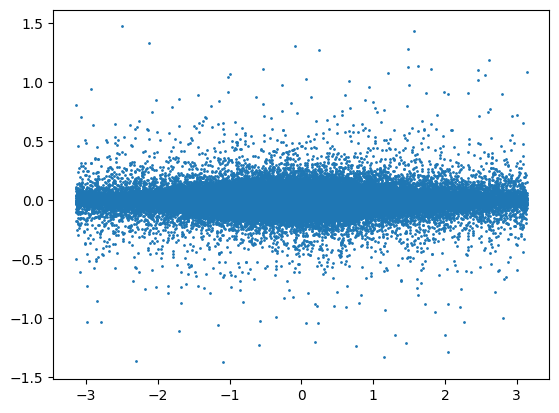

In [3]:
plt.scatter(pulsars.GalLs, pulsars.GalBs, s=1)

In [ ]:
catalog = Read_Catalogue()

mask = (
    (catalog["P0"] != "*")
    & (catalog["P1"] != "*") 
    & (catalog["DIST"] != "*")
)
catalog = { k: catalog[k][mask].astype(float) for k in ["P0", "P1", "DIST"] }

mask = IsNormalPulsar(catalog["P0"], catalog["P1"])

catalog = { k: catalog[k][mask].astype(float) for k in ["P0", "P1", "DIST"] }

In [ ]:
detectable_pulsars = (
    pulsars\
        .select(Detectable_Geometric, PARAMETERS)
        .select(Detectable_Radioflux, PARAMETERS)
        .select(lambda psr, _: IsNormalPulsar(psr.Ps, psr.Pdots), PARAMETERS)
)
detectable_pulsars.number

1963

In [ ]:
catalog

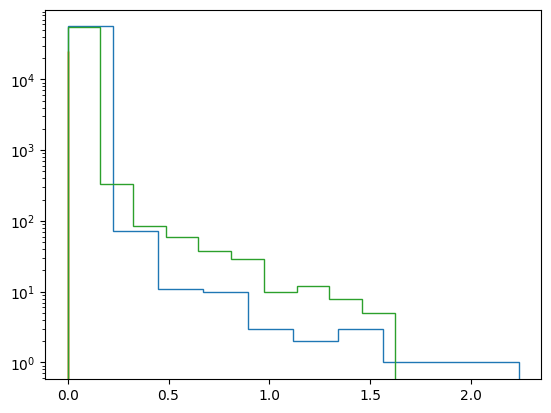

In [ ]:
plt.hist(PARAMETERS['dummy']['w_r_P'], histtype="step")
# plt.hist(PARAMETERS['dummy']['tau_samp_sec'], histtype="step")
plt.hist(PARAMETERS['dummy']['tau_DM_sec'], histtype="step")
plt.hist(PARAMETERS['dummy']['tau_scat_sec'], histtype="step")

plt.yscale("log")

number of observed psrs 2023
number of synthetic psrs 1978
number of all synthetic psrs 475982


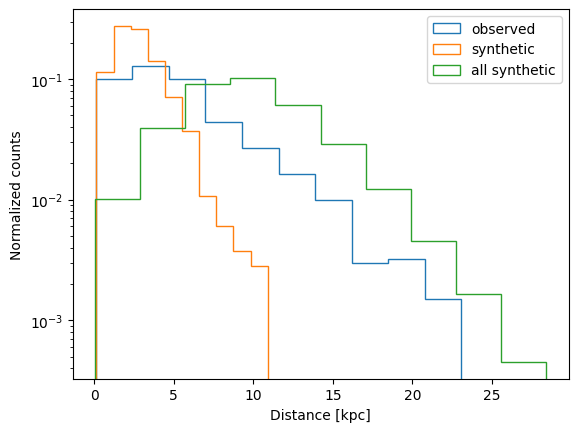

In [ ]:
mask = (catalog["P0"] != "*") & (catalog["P1"] != "*") & (catalog["DIST"] != "*")
dist = catalog["DIST"][mask].astype(float)
p0 = catalog["P0"][mask].astype(float)

observed_dist = dist[(dist < 25) & (p0 > 0.1)]
print("number of observed psrs", len(observed_dist))

synthetic_dist = detectable_pulsars.distances
print("number of synthetic psrs", len(synthetic_dist))

all_synthetic_dist = pulsars.distances
print("number of all synthetic psrs", len(all_synthetic_dist))

plt.hist(observed_dist, histtype="step", density=True, label="observed")
plt.hist(synthetic_dist, histtype="step", density=True, label="synthetic")
plt.hist(all_synthetic_dist, histtype="step", density=True, label="all synthetic")
plt.xlabel("Distance [kpc]")
plt.ylabel("Normalized counts")
plt.legend()
plt.yscale("log")

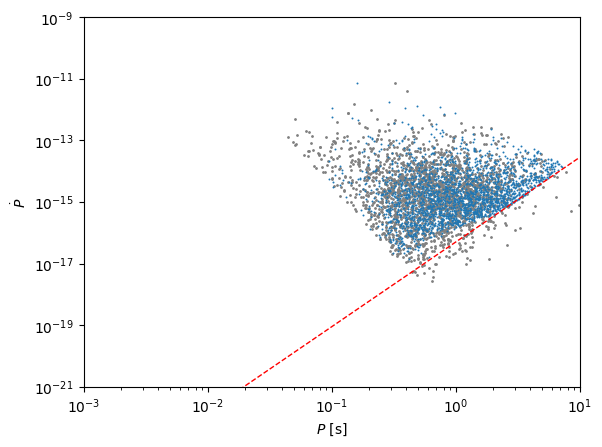

In [ ]:
ax = Plot_PPdot(detectable_pulsars, color=None, s=2, lw=0)

ax.scatter(
    catalog["P0"],
    catalog["P1"],
    s=1,
    color="gray",
    zorder=-1,
)

In [ ]:
# pack the data into 2D arrays

mask = (catalog["P0"] != "*") & (catalog["P1"] != "*")
real_pulsars_P = np.array(catalog["P0"][mask], dtype=float)
real_pulsars_Pdot = np.array(catalog["P1"][mask], dtype=float)
# real_pulsars_Dist = np.array(catalog["DIST_DM"], dtype=float)

# mask out the nan and negative values
mask = (
    # & ~np.isnan(real_pulsars_Dist)
    (real_pulsars_P > 0)
    & (real_pulsars_Pdot > 0)
    # & (real_pulsars_Dist > 0)
    & IsNormalPulsar(real_pulsars_P, real_pulsars_Pdot)
)

real_pulsars = np.array(
    [
        np.log(real_pulsars_P[mask]),
        np.log(real_pulsars_Pdot[mask]),
        # real_pulsars_Dist[mask],
    ]
).T
synthetic_pulsars = np.array(
    [
        np.log(detectable_pulsars.Ps),
        np.log(detectable_pulsars.Pdots),
        # detectable_pulsars.distances,
    ]
).T

In [ ]:
SampleDistance(real_pulsars, synthetic_pulsars)

In [ ]:
np.linspace(2.5, 3.5, 11)

In [ ]:
n_values = np.linspace(2.5, 3.5, 11)
sample_distance_n = []

for n in n_values:
    print("pulsars with n=", n)

    pulsars = Simulate_Evolution(
        birth_rate=0.2 / 100,
        total_time=1e8,
        nbraking=n,
        beta=0.05,
    )

    detected_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)

    real_pulsars = np.array(
        [
            np.log(real_pulsars_P[mask]),
            np.log(real_pulsars_Pdot[mask]),
            # real_pulsars_Dist[mask],
        ]
    ).T
    synthetic_pulsars = np.array(
        [
            np.log(detected_pulsars.Ps),
            np.log(detected_pulsars.Pdots),
            # detectable_pulsars.distances,
        ]
    ).T

    d = SampleDistance(real_pulsars, synthetic_pulsars)
    print(d)
    sample_distance_n.append(d)

In [ ]:
sample_distance_n

In [ ]:
plt.plot(n_values, sample_distance_n)

In [ ]:
np.linspace(0.01, 0.1, 10)

In [ ]:
# same thing as above but for beta values instead of n
beta_values = np.linspace(0.01, 0.1, 10)
sample_distance_b = []

for beta in beta_values:
    print("pulsars with beta=", beta)

    pulsars = Simulate_Evolution(
        birth_rate=0.2 / 100,
        total_time=1e8,
        nbraking=3,
        beta=beta,
    )

    detected_pulsars = pulsars.select(Detectable_Geometric).select(Detectable_Radioflux)

    real_pulsars = np.array(
        [
            np.log(real_pulsars_P[mask]),
            np.log(real_pulsars_Pdot[mask]),
            # real_pulsars_Dist[mask],
        ]
    ).T
    synthetic_pulsars = np.array(
        [
            np.log(detected_pulsars.Ps),
            np.log(detected_pulsars.Pdots),
            # detectable_pulsars.distances,
        ]
    ).T

    d = SampleDistance(real_pulsars, synthetic_pulsars)
    print(d)
    sample_distance_b.append(d)

In [ ]:
plt.plot(beta_values, sample_distance_b)